In [4]:
import torch
import os
from tqdm.notebook import tqdm
from setup_backstep import BackstepProblem
from pod_rbf import err
from quadnet import QuadNet
from corrected_rom import CorrectedROM
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.size'] = 18 
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = ['Computer Modern Roman']
matplotlib.rcParams['image.cmap'] = 'RdBu_r'

In [2]:
dims = [3,5,7,9]
sizes = [10,20,30,40,50,100,150,200]
ndim = len(dims)
ntrain = len(sizes)
errors = np.full((ndim,ntrain),np.nan)

In [3]:
dimtoind = dict(zip(dims,list(range(ndim))))
sizetoind = dict(zip(sizes,list(range(ntrain))))

In [5]:
infile = open("backstep_sensitivity_log_v4.txt")
lines = infile.readlines()
for line in lines:
    if line.startswith("r="):
        chunks = line.strip().split(",")
        dim = chunks[0].split('=')[-1]
        size = chunks[1].split('=')[-1]
        i = dimtoind[int(dim)]
        j = sizetoind[int(size)]
        errors[i,j] = chunks[3].split('=')[-1]
infile.close()

In [6]:
versions = []
for line in lines:
    bits = line.split()
    for bit in bits:
        bit = bit.strip()
        bit = bit.strip(',')
        if bit.startswith('v_num'):
            versions.append(int(bit.split('=')[-1]))

In [7]:
n_queries = 1

error_corrected = np.zeros((ndim,ntrain,n_queries))
error_pod = np.zeros((ndim,ntrain,n_queries))
error_base = np.zeros((ndim,ntrain,n_queries))
error_nointerp = np.zeros((ndim,ntrain,n_queries))
pbar = tqdm(total=ndim*ntrain*n_queries)
for i,reddim in enumerate(dims):
    for j,size in enumerate(sizes):
        for k in range(n_queries):
            backstep = BackstepProblem('mag(v)',reddim=reddim,train_size=size,device='gpu')
    
            # POD-RBF error
            coef_test = backstep.rbf(backstep.params_test)
            pred = backstep.pod.expand(coef_test)
            error_pod[i,j,k] = err(backstep.snapshots_test, pred)[0]
    
            # POD error
            error_base[i,j,k] = err(backstep.snapshots_test, backstep.pod.expand(backstep.pod.reduce(backstep.snapshots_test)))[0]

            id_ = versions[i*ntrain+j]
            corr_net = QuadNet(backstep.modes, backstep.coords)
        
            directory = os.path.join("./",f'lightning_logs/version_{id_}/checkpoints/')
            filename = os.listdir(directory)[0]
            print(id_, reddim, size,filename)
    
            rom = CorrectedROM.load_from_checkpoint(
                    checkpoint_path=os.path.join(directory,filename),
                    problem = backstep.problem,
                   reduction_network = backstep.pod,
                   interpolation_network = backstep.rbf,
                   correction_network = corr_net)
            #rom.cpu()
            rom.eval()
            # Corrected error NO INTERPOLATION
            pred = rom._forward_no_interp(backstep.params_test,backstep.snapshots_test)
            error_nointerp[i,j,k] = err(backstep.snapshots_test, pred)[0]
            
            #Corrected error
            pred = rom(backstep.params_test)
            error_corrected[i,j,k] = err(backstep.snapshots_test,pred)[0]
            pbar.update(1)

#error_corrected /= n_queries
#error_pod /= n_queries
#error_base /= n_queries
#error_nointerp /= n_queries


  0%|          | 0/32 [00:00<?, ?it/s]

1063 3 10 epoch=19999-step=20000.ckpt
1064 3 20 epoch=19999-step=80000.ckpt
1065 3 30 epoch=13660-step=68305.ckpt
1066 3 40 epoch=19999-step=80000.ckpt
1067 3 50 epoch=15803-step=79020.ckpt
1068 3 100 epoch=19999-step=80000.ckpt
1069 3 150 epoch=19999-step=100000.ckpt
1070 3 200 epoch=19999-step=80000.ckpt
1071 5 10 epoch=19999-step=20000.ckpt
1072 5 20 epoch=19999-step=80000.ckpt
1073 5 30 epoch=19999-step=100000.ckpt
1074 5 40 epoch=19999-step=80000.ckpt
1075 5 50 epoch=19999-step=100000.ckpt
1076 5 100 epoch=19999-step=80000.ckpt
1077 5 150 epoch=19999-step=100000.ckpt
1078 5 200 epoch=19999-step=80000.ckpt
1095 7 10 epoch=49999-step=50000.ckpt
1096 7 20 epoch=49999-step=200000.ckpt
1097 7 30 epoch=49999-step=250000.ckpt
1098 7 40 epoch=49999-step=200000.ckpt
1099 7 50 epoch=49999-step=250000.ckpt
1100 7 100 epoch=49999-step=200000.ckpt
1101 7 150 epoch=49999-step=250000.ckpt
1102 7 200 epoch=49999-step=200000.ckpt
1103 9 10 epoch=49999-step=50000.ckpt
1104 9 20 epoch=49999-step=200

In [60]:
torch.allclose(rom.neural_net['interpolation_network'](backstep.params_test),coef_test)

True

In [12]:
error_pod.std(axis=-1)

array([[3.21555320e-07, 4.99991494e-07, 1.21868844e-07, 1.45702461e-07,
        2.98150817e-07, 8.16760425e-08, 1.00063794e-06, 1.95022275e-06],
       [3.48683988e-07, 4.81138605e-07, 1.77855318e-07, 1.67222332e-07,
        3.47975968e-07, 5.36498585e-07, 2.23062599e-06, 5.25120647e-06],
       [4.21954579e-07, 6.34266994e-07, 2.82505934e-07, 2.71970541e-07,
        4.47775485e-07, 1.22864969e-06, 4.34075051e-06, 1.08488378e-05],
       [3.28466888e-07, 6.30283732e-07, 3.35544226e-07, 2.59056029e-07,
        4.18107287e-07, 2.07627042e-06, 6.80204948e-06, 1.88899130e-05]])

In [54]:
error_pod.mean(axis=-1)

array([[0.2792818 , 0.20074637, 0.021832  , 0.02248393, 0.02296204,
        0.01704304, 0.01440787, 0.01460602],
       [0.27797455, 0.19713977, 0.01366423, 0.0137358 , 0.01384423,
        0.00697576, 0.00434069, 0.00465113],
       [0.27781808, 0.1963848 , 0.01110754, 0.01117891, 0.01113977,
        0.00447936, 0.0017594 , 0.0018338 ],
       [0.2778044 , 0.19613822, 0.010412  , 0.01019985, 0.01019472,
        0.00357678, 0.00095768, 0.00103718]])

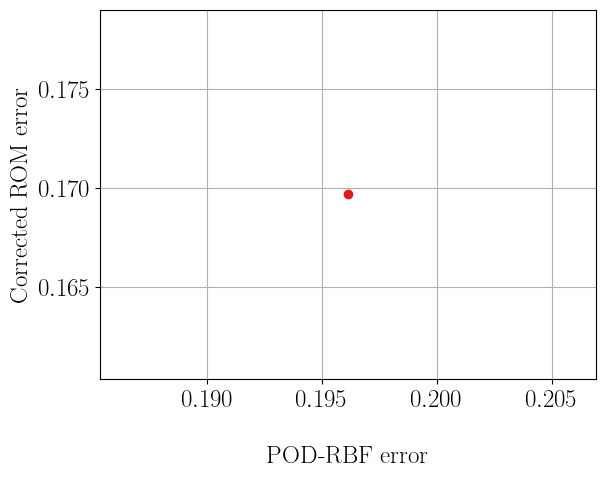

In [55]:
plt.scatter(error_pod[-1,1,:],error_corrected[-1,1,:])
plt.gca().set_xlabel('POD-RBF error')
plt.gca().set_ylabel('Corrected ROM error')
plt.gca().xaxis.labelpad=25
plt.gca().grid()

In [8]:
error_corrected = error_corrected.mean(axis=-1)
error_pod = error_pod.mean(axis=-1)
error_base = error_base.mean(axis=-1)
error_nointerp = error_nointerp.mean(axis=-1)

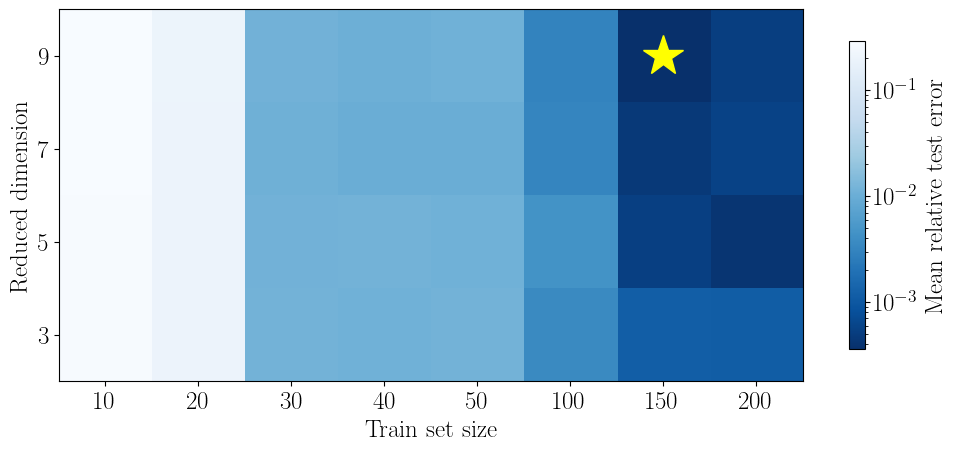

In [9]:
fig,ax = plt.subplots(figsize=(12,5))
heat = ax.imshow(error_corrected,cmap='Blues_r',norm=matplotlib.colors.LogNorm())
ax.invert_yaxis()
ax.set_xticks(range(ntrain),sizes)
ax.set_yticks(range(ndim),dims)
ax.set_xlabel('Train set size')
ax.set_ylabel('Reduced dimension')

best = np.unravel_index(error_corrected.argmin(),error_corrected.shape)
ax.plot(best[1],best[0],'#FFFF00',marker=r'*',ms=30)#,markeredgewidth=5)
#square = matplotlib.patches.Rectangle((best[1]-0.5,best[0]-0.5),1,1,fill=False,edgecolor='r',lw=3)
#ax.add_patch(square)

#for i in range(4):
#    for j in range(8):
#        ax.text(j,i,f'{errors[i,j]:.2e}',c='k',ha='center',va='center',fontsize=14)

fig.colorbar(heat,shrink=0.8,label='Mean relative test error')
#fig.savefig('./sensitivity_analysis/backstep/correction_error')

In [10]:
time = 0
for line in lines:
    bits = line.split()
    for bit in bits:
        bit = bit.strip()
        bit = bit.strip(',')
        if bit.startswith('train_time'):
            time += float(bit.split('=')[-1])

In [11]:
time/3600

19.506882977816794

In [12]:
loss = np.empty(32)
i = 0
for line in lines:
    bits = line.split()
    for bit in bits:
        bit = bit.strip()
        bit = bit.strip(',')
        if bit.startswith('loss_corr'):
            loss[i] = float(bit.split('=')[-1])
            i += 1
loss = loss.reshape((4,8))

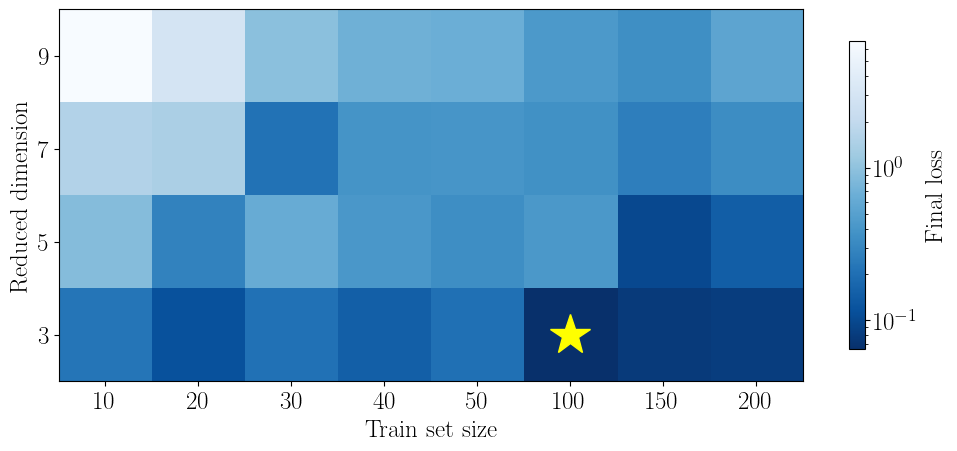

In [13]:
fig,ax = plt.subplots(figsize=(12,5))
heat = ax.imshow(loss,cmap='Blues_r',norm=matplotlib.colors.LogNorm())
ax.invert_yaxis()
ax.set_xticks(range(ntrain),sizes)
ax.set_yticks(range(ndim),dims)
ax.set_xlabel('Train set size')
ax.set_ylabel('Reduced dimension')

best = np.unravel_index(loss.argmin(),loss.shape)
ax.plot(best[1],best[0],'#FFFF00',marker=r'*',ms=30)
#square = matplotlib.patches.Rectangle((best[1]-0.5,best[0]-0.5),1,1,fill=False,edgecolor='r',lw=3)
#ax.add_patch(square)

#for i in range(4):
#    for j in range(8):
#        ax.text(j,i,f'{loss[i,j]:.2e}',c='k',ha='center',va='center',fontsize=14)

fig.colorbar(heat,shrink=0.8,label='Final loss')
#fig.savefig('./sensitivity_analysis/backstep/final_loss')

## POD RBF

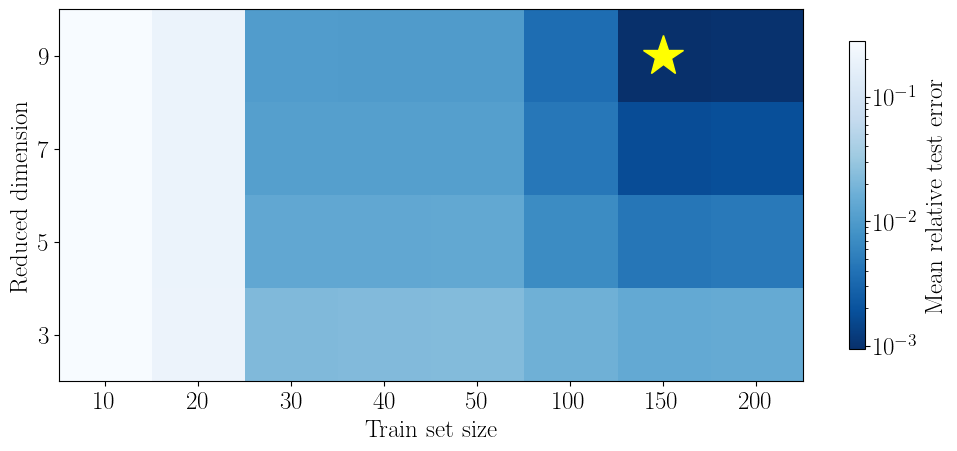

In [14]:
fig,ax = plt.subplots(figsize=(12,5))
heat = ax.imshow(error_pod,cmap='Blues_r',norm=matplotlib.colors.LogNorm())
ax.invert_yaxis()
ax.set_xticks(range(ntrain),sizes)
ax.set_yticks(range(ndim),dims)
ax.set_xlabel('Train set size')
ax.set_ylabel('Reduced dimension')

best = np.unravel_index(error_pod.argmin(),error_pod.shape)
ax.plot(best[1],best[0],'#FFFF00',marker=r'*',ms=30)
#square = matplotlib.patches.Rectangle((best[1]-0.5,best[0]-0.5),1,1,fill=False,edgecolor='r',lw=3)
#ax.add_patch(square)

#for i in range(4):
#    for j in range(8):
#        ax.text(j,i,f'{error_pod[i,j]:.2e}',c='k',ha='center',va='center',fontsize=14)

fig.colorbar(heat,shrink=0.8,label='Mean relative test error')
#fig.savefig('./sensitivity_analysis/backstep/podrbf_error')


In [16]:
error_pod

array([[0.27928159, 0.20074649, 0.02183218, 0.0224835 , 0.022962  ,
        0.01704306, 0.01440986, 0.01461265],
       [0.27797437, 0.19713838, 0.01366404, 0.01373604, 0.01384442,
        0.00697588, 0.00434109, 0.00465356],
       [0.27781743, 0.19638443, 0.0111081 , 0.01117877, 0.01114006,
        0.00448137, 0.00175536, 0.00184421],
       [0.27780408, 0.19613762, 0.01041199, 0.01019953, 0.01019546,
        0.00357602, 0.00093357, 0.00099074]])

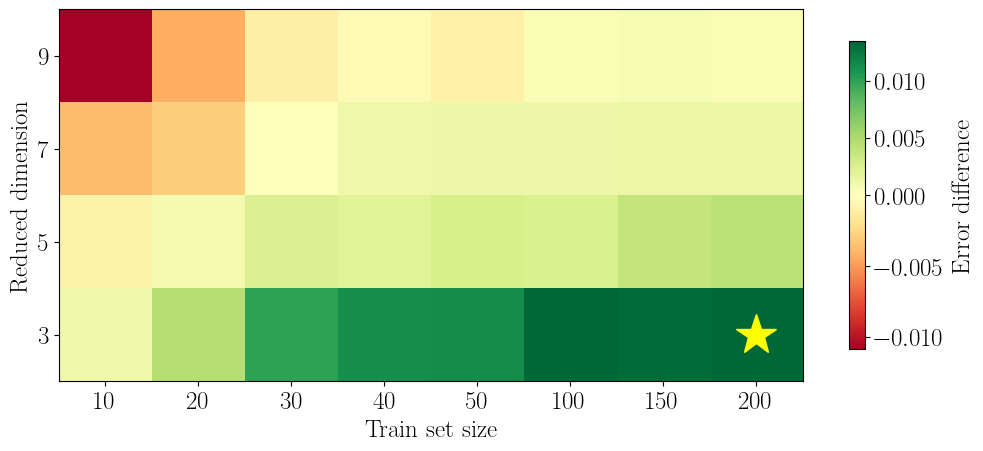

In [15]:
difference = (error_pod - error_corrected)#/error_pod
fig,ax = plt.subplots(figsize=(12,5))
#heat = ax.imshow((difference>0),cmap=matplotlib.colors.ListedColormap(['#FF7373','#73FF73']))#,norm=matplotlib.colors.TwoSlopeNorm(0,-0.06,0.06))
heat = ax.imshow((difference),cmap='RdYlGn',norm=matplotlib.colors.TwoSlopeNorm(0,difference.min(),difference.max()))
ax.invert_yaxis()
ax.set_xticks(range(ntrain),sizes)
ax.set_yticks(range(ndim),dims)
ax.set_xlabel('Train set size')
ax.set_ylabel('Reduced dimension')


best = np.unravel_index(difference.argmax(),difference.shape)
ax.plot(best[1],best[0],'#FFFF00',marker=r'*',ms=30)
#square = matplotlib.patches.Rectangle((best[1]-0.5,best[0]-0.5),1,1,fill=False,edgecolor='r',lw=3)
#ax.add_patch(square)

#for i in range(4):
#    for j in range(8):
#        ax.text(j,i,f'{difference[i,j]:.2e}',c='k',ha='center',va='center',fontsize=14)

fig.colorbar(heat,shrink=0.8,label='Error difference')#,extend='min')
#fig.savefig('./sensitivity_analysis/backstep/error_difference_absolute')


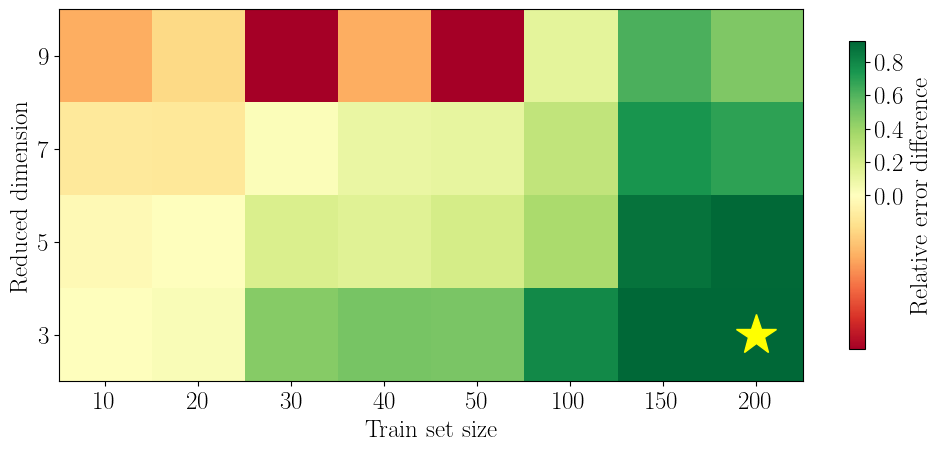

In [44]:
difference = (error_pod - error_corrected)/error_pod #* 100
fig,ax = plt.subplots(figsize=(12,5))
heat = ax.imshow(difference,cmap='RdYlGn',norm=matplotlib.colors.TwoSlopeNorm(0,difference.min(),difference.max()))
ax.invert_yaxis()
ax.set_xticks(range(ntrain),sizes)
ax.set_yticks(range(ndim),dims)
ax.set_xlabel('Train set size')
ax.set_ylabel('Reduced dimension')

best = np.unravel_index(difference.argmax(),difference.shape)
ax.plot(best[1],best[0],'#FFFF00',marker=r'*',ms=30)
#square = matplotlib.patches.Rectangle((best[1]-0.5,best[0]-0.5),1,1,fill=False,edgecolor='r',lw=3)
#ax.add_patch(square)

#textcols = ['w','k']
#th = 0.6
#th1 = heat.norm(-th)
#th2 = heat.norm(th)
#for i in range(4):
#    for j in range(8):
#        col = textcols[int(th1<heat.norm(difference[i,j])<th2)]
#        ax.text(j,i,f'{difference[i,j]:.2f}',c=col,ha='center',va='center',fontsize=18)

cbar = fig.colorbar(heat,shrink=0.8,label='Relative error difference')#,extend='min',ticks=[-0.05,0,0.2,0.4,0.6,0.8,1])

#fig.savefig('./sensitivity_analysis/backstep/error_difference_relative')


In [20]:
cm = plt.get_cmap('RdBu_r')
cols = cm(np.linspace(0.1,0.9,4))

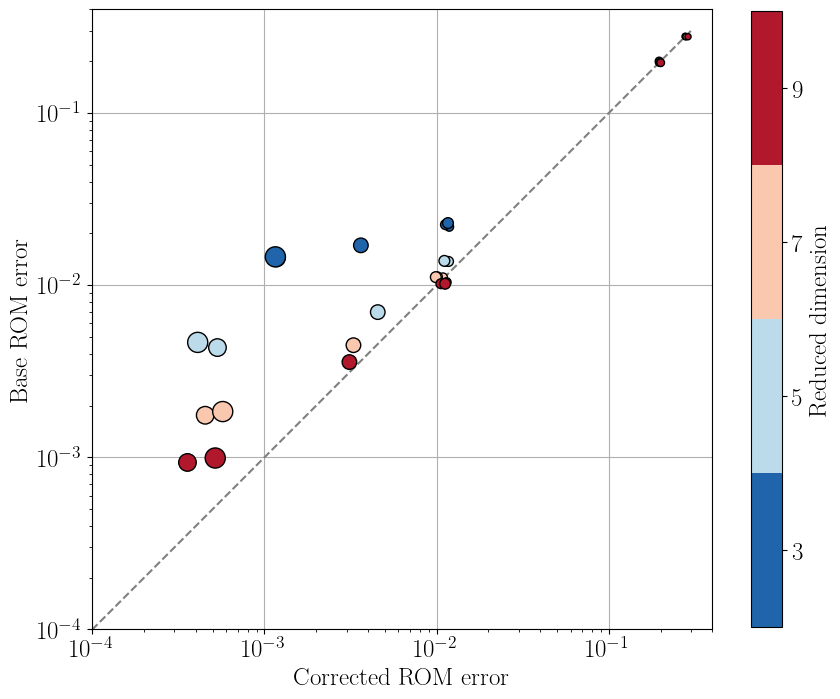

In [21]:
def custom_cmap(x):
    return np.where(x,'green','red').ravel()

colors = custom_cmap(error_pod>error_corrected)

dim_arr = np.array(dims).repeat(8).reshape((4,8))
size_arr = np.array(sizes)[None,:].repeat(4,axis=0)

fig, ax = plt.subplots(figsize=(10,10))
ax.set_xlim(1e-4,4e-1)
ax.set_ylim(1e-4,4e-1)
ax.set_aspect('equal')
ax.grid()
scat = ax.scatter(error_corrected,error_pod,marker='o',c=dim_arr,s=size_arr+10,zorder=10,cmap=matplotlib.colors.ListedColormap(cols),edgecolors='k')
ax.loglog(np.array([0,0.3]).T,np.array([0,0.3]).T,'--',c='grey')
ax.set_xlabel('Corrected ROM error')
ax.set_ylabel('Base ROM error')
cbar = plt.colorbar(scat,shrink=0.8,label='Reduced dimension',ticks=dims,boundaries=np.arange(2,11,2))
#fig.savefig('./sensitivity_analysis/backstep/podrbf_correction_scatter')


## Compare with base POD (no RBF)

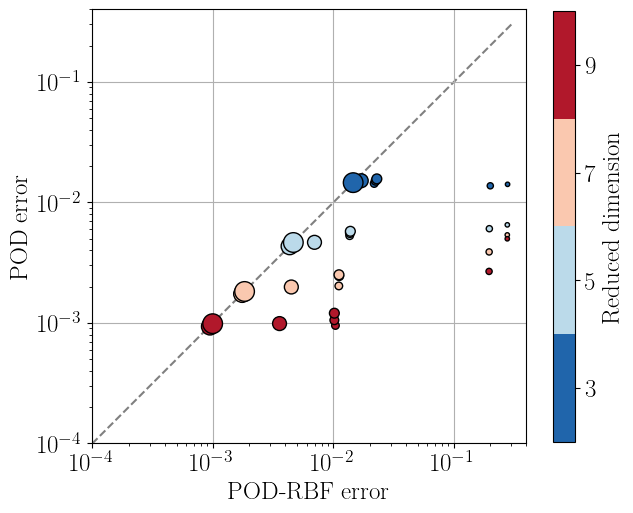

In [20]:
def custom_cmap(x):
    return np.where(x,'green','red').ravel()

colors = custom_cmap(error_base>error_pod)

dim_arr = np.array(dims).repeat(8).reshape((4,8))
size_arr = np.array(sizes)[None,:].repeat(4,axis=0)

fig, ax = plt.subplots(figsize=(7,7))
ax.set_xlim(1e-4,4e-1)
ax.set_ylim(1e-4,4e-1)
ax.set_aspect('equal')
ax.grid(zorder=-10)
ax.loglog(np.array([0,0.3]).T,np.array([0,0.3]).T,'--',c='grey',zorder=-1)
scat = ax.scatter(error_pod,error_base,marker='o',c=dim_arr,s=size_arr,zorder=10,edgecolors='k',cmap=matplotlib.colors.ListedColormap(cols))
ax.set_xlabel('POD-RBF error')
ax.set_ylabel('POD error')
plt.colorbar(scat,shrink=0.8,label='Reduced dimension',ticks=dims,boundaries=np.arange(2,11,2))

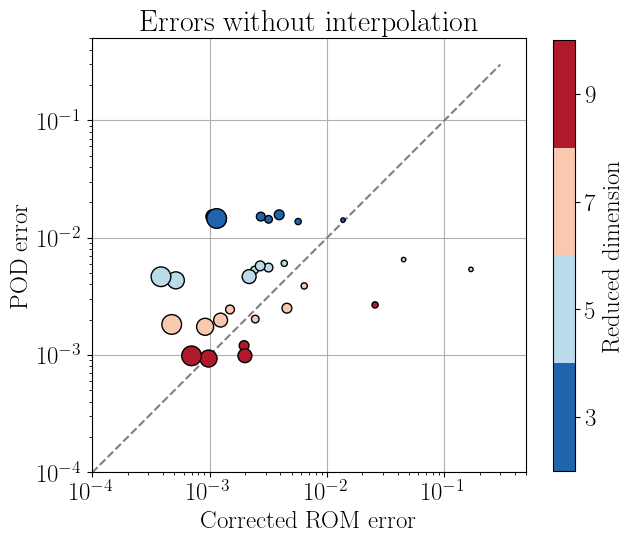

In [45]:
def custom_cmap(x):
    return np.where(x,'green','red').ravel()

colors = custom_cmap(error_base>error_nointerp)

fig, ax = plt.subplots(figsize=(7,7))
ax.set_xlim(1e-4,5e-1)
ax.set_ylim(1e-4,5e-1)
ax.set_aspect('equal')
ax.grid()
scat = ax.scatter(error_nointerp,error_base,marker='o',c=dim_arr,s=size_arr,zorder=10,edgecolors='k',cmap=matplotlib.colors.ListedColormap(cols))
ax.loglog(np.array([0,0.3]).T,np.array([0,0.3]).T,'--',c='grey')
ax.set_title('Errors without interpolation')
ax.set_xlabel('Corrected ROM error')
ax.set_ylabel('POD error')
plt.colorbar(scat,shrink=0.8,label='Reduced dimension',ticks=dims,boundaries=np.arange(2,11,2))


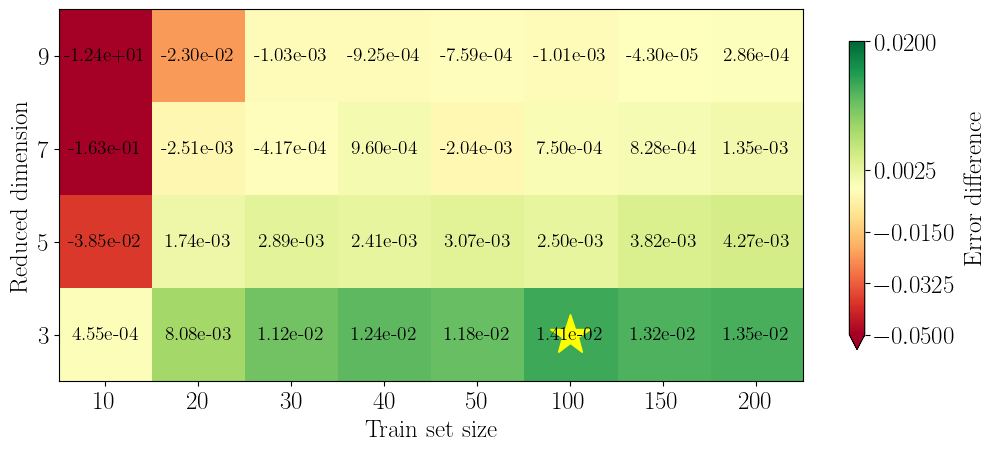

In [42]:
difference = (error_base - error_nointerp)
fig,ax = plt.subplots(figsize=(12,5))
#heat = ax.imshow((difference>0),cmap=matplotlib.colors.ListedColormap(['#FFB3B3','#B3FFAD']))#,norm=matplotlib.colors.TwoSlopeNorm(0,-0.06,0.06))
heat = ax.imshow((difference),cmap='RdYlGn',norm=matplotlib.colors.TwoSlopeNorm(0,-5e-2,2e-2))
ax.invert_yaxis()
ax.set_xticks(range(ntrain),sizes)
ax.set_yticks(range(ndim),dims)
ax.set_xlabel('Train set size')
ax.set_ylabel('Reduced dimension')

best = np.unravel_index(difference.argmax(),errors.shape)
ax.plot(best[1],best[0],'#FFFF00',marker=r'*',ms=30)
#square = matplotlib.patches.Rectangle((best[1]-0.5,best[0]-0.5),1,1,fill=False,edgecolor='r',lw=3)
#ax.add_patch(square)

for i in range(4):
    for j in range(8):
        ax.text(j,i,f'{difference[i,j]:.2e}',c='k',ha='center',va='center',fontsize=14)

fig.colorbar(heat,shrink=0.8,label='Error difference',ticks=np.linspace(-5e-2,2e-2,5),extend='min')

## Tests on reproducibility
Turns out that both the modes and rbf for different instances of the problem are not equal. The train and test data seems to be the same, which is expected as the train-test split has a seed. This causes issues in experiments since the results vary noticeably from case to case.

In [112]:
torch.manual_seed(10)

In [73]:
b1 = BackstepProblem('mag(v)',reddim=20,train_size=100)
b2 = BackstepProblem('mag(v)',reddim=20,train_size=100)
b3 = BackstepProblem('mag(v)',reddim=20,train_size=100)

print(torch.allclose(b1.params_train,b2.params_train))
print(torch.allclose(b2.params_train,b3.params_train))
print(torch.allclose(b1.params_train,b3.params_train))

print(torch.allclose(b1.params_test,b2.params_test))
print(torch.allclose(b2.params_test,b3.params_test))
print(torch.allclose(b1.params_test,b3.params_test))

True
True
True
True
True
True


In [74]:
print(torch.allclose(b1.modes,b2.modes))
print(torch.allclose(b2.modes,b3.modes))
print(torch.allclose(b1.modes,b3.modes))

False
False
False


In [75]:
print((b1.modes-b2.modes).mean())
print((b2.modes-b3.modes).mean())
print((b1.modes-b3.modes).mean())

no labels
LabelTensor(0.0001)
no labels
LabelTensor(-0.0003)
no labels
LabelTensor(-0.0001)


In [76]:
print(torch.allclose(b1.rbf._coeffs,b2.rbf._coeffs))
print(torch.allclose(b2.rbf._coeffs,b3.rbf._coeffs))
print(torch.allclose(b1.rbf._coeffs,b3.rbf._coeffs))

False
False
False


In [77]:
print((b1.rbf._coeffs - b2.rbf._coeffs).mean())
print((b2.rbf._coeffs - b3.rbf._coeffs).mean())
print((b1.rbf._coeffs - b3.rbf._coeffs).mean())

tensor(0.0007)
tensor(0.0003)
tensor(0.0010)


In [78]:
print(torch.allclose(b1.rbf(b1.params_test), b2.rbf(b2.params_test)))
print(torch.allclose(b2.rbf(b2.params_test), b3.rbf(b3.params_test)))
print(torch.allclose(b1.rbf(b1.params_test), b3.rbf(b3.params_test)))

False
False
False


In [79]:
print((b1.rbf(b1.params_test) - b2.rbf(b2.params_test)).mean())
print((b2.rbf(b2.params_test) - b3.rbf(b3.params_test)).mean())
print((b1.rbf(b1.params_test) - b3.rbf(b3.params_test)).mean())

no labels
LabelTensor(0.0501)
no labels
LabelTensor(-0.0697)
no labels
LabelTensor(-0.0196)


In [228]:
errors,np.load('sensitivity_analysis/backstep/error_corrected.npy').mean(axis=-1)

(array([[0.27815476, 0.19611286, 0.01054723, 0.01046044, 0.01060426,
         0.00392364, 0.00090173, 0.00121473],
        [0.27790278, 0.19654743, 0.01126086, 0.01385556, 0.01094683,
         0.00410349, 0.00041005, 0.00046865],
        [0.27897593, 0.19800536, 0.01059462, 0.01086973, 0.01118629,
         0.00418355, 0.0007168 , 0.00042887],
        [0.27973393, 0.20118335, 0.01440172, 0.01052035, 0.01040367,
         0.00350565, 0.00066814, 0.00074604]]),
 array([[0.29367309, 0.2035673 , 0.01767486, 0.01751679, 0.01632876,
         0.01498386, 0.01180835, 0.0188445 ],
        [0.29637963, 0.19821653, 0.01362511, 0.01736179, 0.01369086,
         0.01043118, 0.00556822, 0.00748556],
        [0.30689331, 0.20466073, 0.01524994, 0.02079485, 0.06790551,
         0.01649613, 0.00258081, 0.00481783],
        [0.26756918, 0.20935175, 0.0563684 , 0.06597037, 0.05381406,
         0.03939582, 0.02391483, 0.02242672]]))

In [229]:
e_c = np.load('sensitivity_analysis/backstep/error_corrected.npy')

(array([ 7.,  0.,  0.,  0.,  0.,  0., 31., 10.,  1., 51.]),
 array([0.00121395, 0.00351285, 0.00581176, 0.00811066, 0.01040956,
        0.01270846, 0.01500737, 0.01730627, 0.01960517, 0.02190408,
        0.02420298]),
 <BarContainer object of 10 artists>)

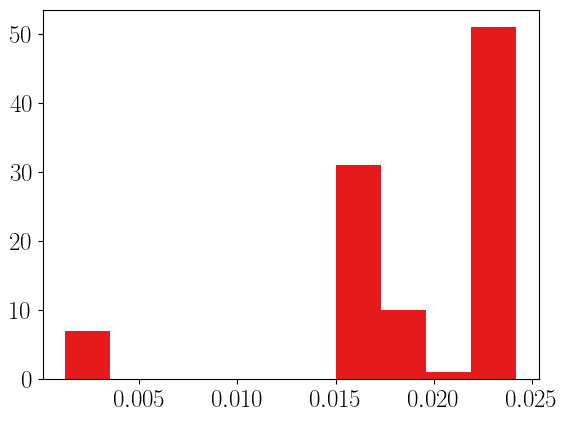

In [230]:
plt.hist(e_c[0,-1,:])

In [69]:
corr_net.modes = backstep.modes
a = rom(backstep.params_test[0])
corr_net.modes = corr_net.modes+torch.randn(corr_net.modes.shape)*1e-4
b = rom(backstep.params_test[0])

(array([  3.,   4.,  32., 315., 935., 311.,  31.,   4.,   2.,   2.]),
 array([-3.06457281e-04, -2.37935776e-04, -1.69414285e-04, -1.00892779e-04,
        -3.23712811e-05,  3.61502171e-05,  1.04671715e-04,  1.73193213e-04,
         2.41714719e-04,  3.10236210e-04,  3.78757715e-04]),
 <BarContainer object of 10 artists>)

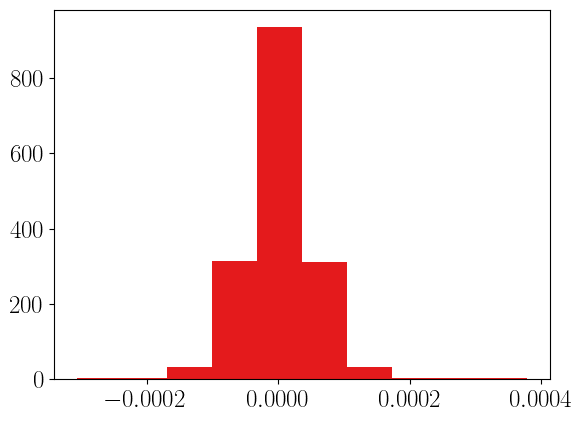

In [72]:
plt.hist((a-b).detach().numpy().ravel())

In [64]:
ref = BackstepProblem('mag(v)',reddim=5,train_size=100)
for i in range(100):
    pr = BackstepProblem('mag(v)',reddim=5,train_size=100)
    if not torch.allclose(ref.params_test,pr.params_test):
        print('params test different',i)
    if not torch.allclose(ref.params_train,pr.params_train):
        print('params train different',i)
    if not torch.allclose(ref.snapshots_test,pr.snapshots_test):
        print('snaps test different',i)
    if not torch.allclose(ref.snapshots_train,pr.snapshots_train):
        print('snaps train different',i)
    if not torch.allclose(ref.modes,pr.modes):
        print('modes different',i)

modes different 0
modes different 1
modes different 2
modes different 3
modes different 4
modes different 5
modes different 6
modes different 7
modes different 8
modes different 9
modes different 10
modes different 11
modes different 12
modes different 13
modes different 14
modes different 15
modes different 16
modes different 17
modes different 18
modes different 19
modes different 20
modes different 21
modes different 22
modes different 23
modes different 24
modes different 25
modes different 26
modes different 27
modes different 28
modes different 29
modes different 30
modes different 31
modes different 32
modes different 33
modes different 34
modes different 35
modes different 36
modes different 37
modes different 38
modes different 39
modes different 40
modes different 41
modes different 42
modes different 43
modes different 44
modes different 45
modes different 46
modes different 47
modes different 48
modes different 49
modes different 50
modes different 51
modes different 52
mod